# Kr analysis (run 3575)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Sat Apr  8 13:48:16 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [81]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (41.5/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def load_dst(filename):
    with tb.open_file(filename) as h5:
        return pd.DataFrame.from_records(h5.root.DST.KrEvents.read())

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
ifiles = glob.glob(os.path.expandvars("/Users/Gonzalo/github/NEXTdata/Na22/3575/dst*.h5"))
ifile = os.path.expandvars("$IC_DATA/kdst_3609_135_479.h5")
print("ifile:", len(ifiles))

ifile: 335


# Read data

In [5]:
#full = functools.reduce(lambda x,y: pd.concat((x,y)), [load_dst(ifile) for ifile in ifiles])
#full.Z *= 1e-6
full = load_dst(ifile)
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,22141,1.491517e+09,0,1,175.0,13.954955,72.239815,624025.0,18.015812,16397.771484,...,659462.5,26.0,35.4375,35.4375,-141.485719,-4.030394,141.543113,-3.113114,10.746290,9.177835
1,22143,1.491517e+09,0,2,175.0,14.436388,73.639985,570075.0,16.071250,8490.367188,...,659187.5,19.0,89.1125,89.1125,-97.569578,22.380145,100.103414,2.916117,8.997476,9.208689
2,22143,1.491517e+09,1,2,175.0,14.436388,73.639985,570075.0,7.319375,1538.694702,...,676287.5,2.0,106.2125,106.2125,-119.837734,25.000000,122.417656,2.935927,5.021407,0.000000
3,22144,1.491517e+09,0,2,300.0,25.215143,152.466999,565475.0,19.281437,13409.538086,...,655262.5,30.0,89.7875,89.7875,54.959338,-26.589229,61.053386,-0.450602,10.232118,10.337627
4,22144,1.491517e+09,1,2,300.0,25.215143,152.466999,565475.0,8.328125,4597.053711,...,681487.5,8.0,116.0125,116.0125,36.625278,13.021865,38.871326,0.341604,6.569558,6.368801


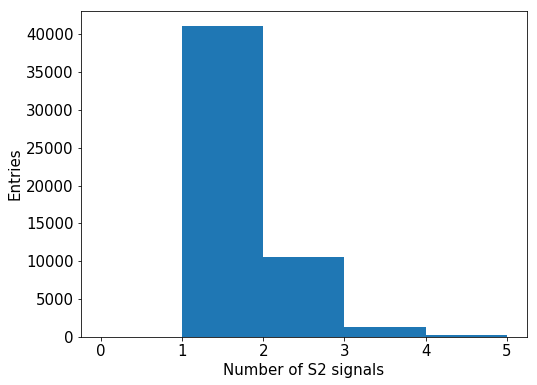

In [6]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

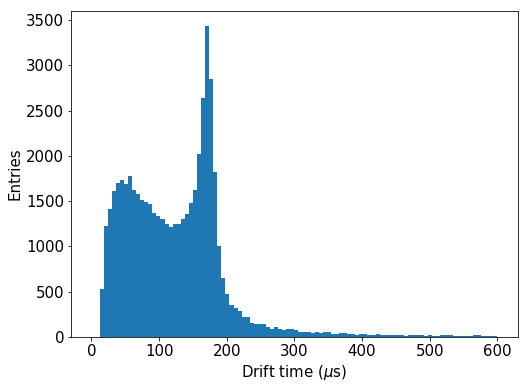

In [7]:
hist(full.Z, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")

In [8]:
7000/41.5*511

86192.77108433735

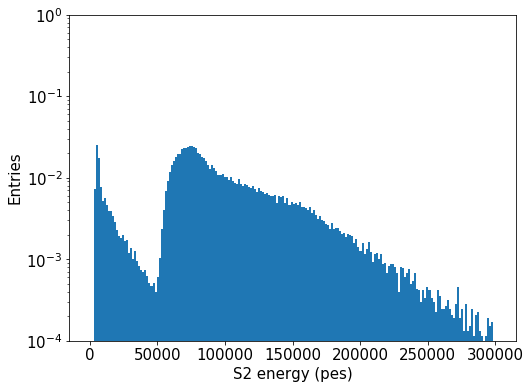

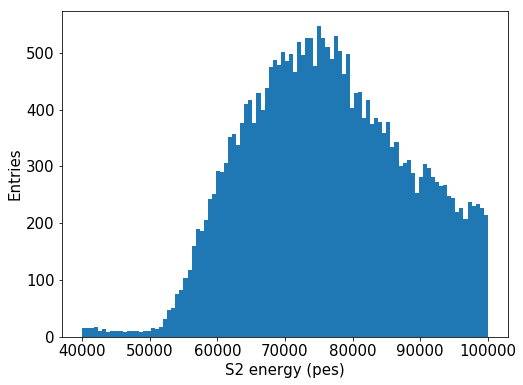

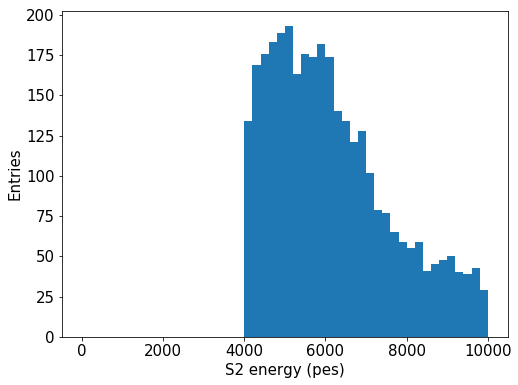

In [37]:
pdf(full.S2e, 200, (0,3e5))
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 100, (4e4,1e5))
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 50, (0,1e4))
labels("S2 energy (pes)", "Entries")

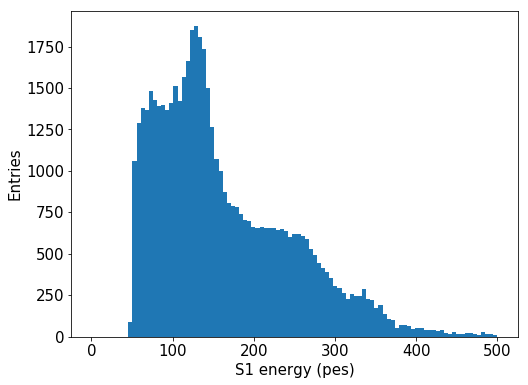

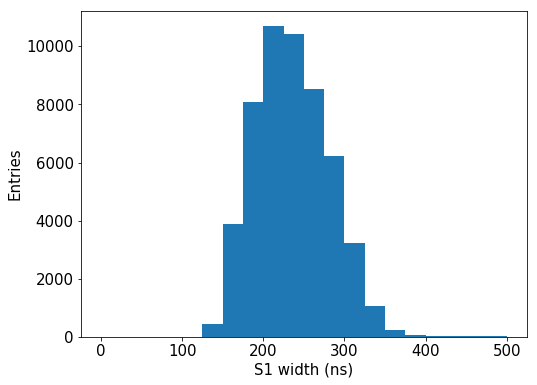

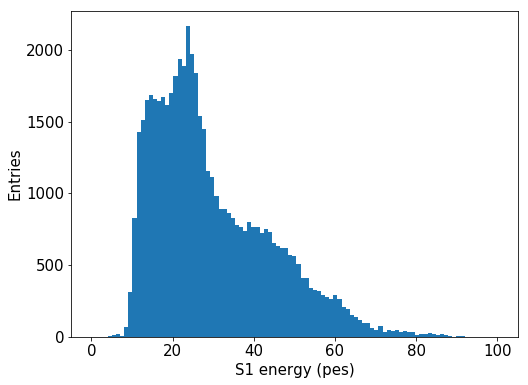

In [38]:
bins = np.linspace(0, 500, 100)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 100, 100)
hist(full.S1h, bins)
labels("S1 energy (pes)", "Entries")

# S2 energy vs Z

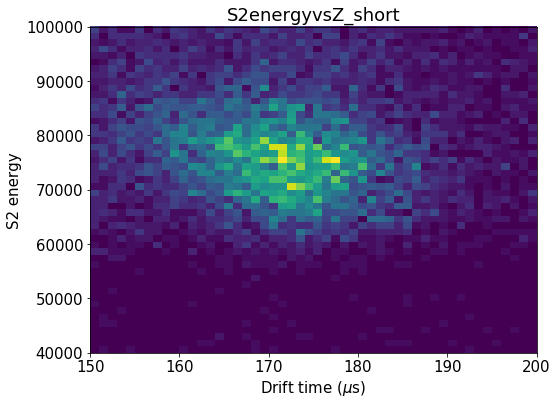

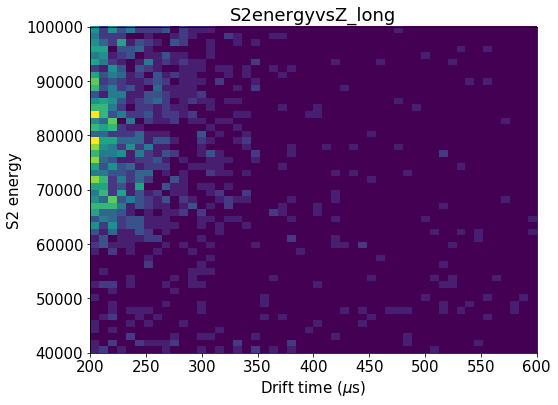

In [40]:
zrange = 150, 200
Erange = 4e4, 1e5
hist2d(full.Z, full.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zrange = 200, 600
hist2d(full.Z, full.S2e, (50,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_long")

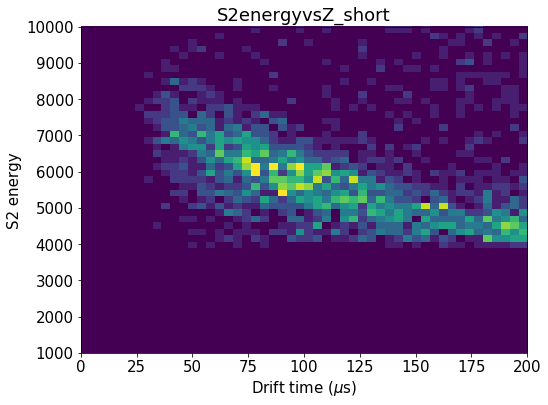

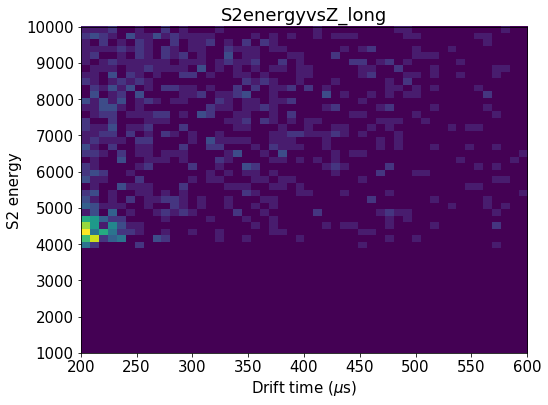

In [41]:
zrange =   0, 200
Erange =  1e3, 1e4
hist2d(full.Z, full.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zrange = 200, 600
Erange = 1e3, 1e4
hist2d(full.Z, full.S2e, (50,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_long")

# Short drift time: Z < 250 $\mu$s

In [42]:
zcut = 250
shortZ = full[full.Z < zcut]
print("Ratio:", len(shortZ)/len(full))
shortZ.head()

Ratio: 0.9568292406925427


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,22141,1.491517e+09,0,1,175.0,13.954955,72.239815,624025.0,18.015812,16397.771484,...,659462.5,26.0,35.4375,35.4375,-141.485719,-4.030394,141.543113,-3.113114,10.746290,9.177835
1,22143,1.491517e+09,0,2,175.0,14.436388,73.639985,570075.0,16.071250,8490.367188,...,659187.5,19.0,89.1125,89.1125,-97.569578,22.380145,100.103414,2.916117,8.997476,9.208689
2,22143,1.491517e+09,1,2,175.0,14.436388,73.639985,570075.0,7.319375,1538.694702,...,676287.5,2.0,106.2125,106.2125,-119.837734,25.000000,122.417656,2.935927,5.021407,0.000000
3,22144,1.491517e+09,0,2,300.0,25.215143,152.466999,565475.0,19.281437,13409.538086,...,655262.5,30.0,89.7875,89.7875,54.959338,-26.589229,61.053386,-0.450602,10.232118,10.337627
4,22144,1.491517e+09,1,2,300.0,25.215143,152.466999,565475.0,8.328125,4597.053711,...,681487.5,8.0,116.0125,116.0125,36.625278,13.021865,38.871326,0.341604,6.569558,6.368801


# S1 energy

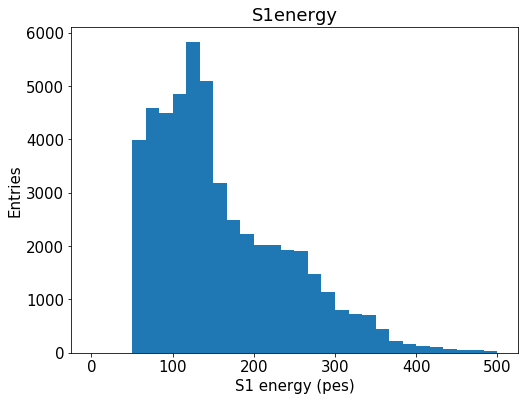

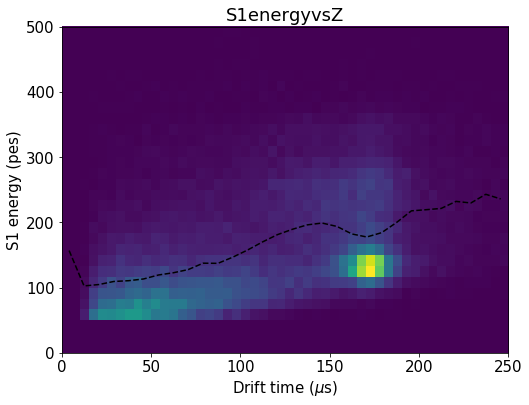

In [43]:
zrange = 0, zcut
Srange = 0, 500

hist(shortZ.S1e, 30, range=Srange)
labels("S1 energy (pes)", "Entries")
save("S1energy")

hist2d(shortZ.Z, shortZ.S1e, (50, 30), range=(zrange, Srange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1e, 30, xrange=zrange, yrange=Srange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

# S1 width

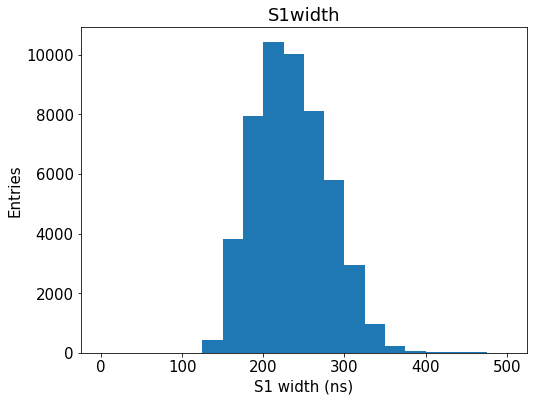

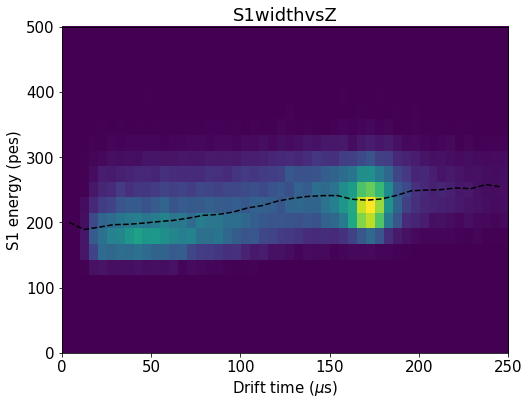

In [44]:
zrange = 0, zcut
wrange = 0, 500

hist(shortZ.S1w, np.linspace(*wrange, 21))
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(shortZ.Z, shortZ.S1w, (50, 21), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

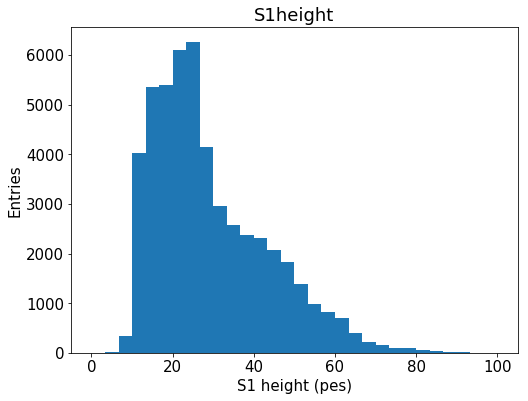

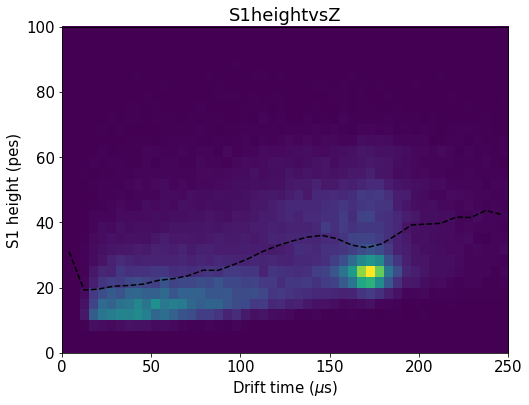

In [45]:
zrange = 0, zcut
hrange = 0, 100

hist(shortZ.S1h, 30, range=hrange)
labels("S1 height (pes)", "Entries")
save("S1height")

hist2d(shortZ.Z, shortZ.S1h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

# S1 peak to area ratio

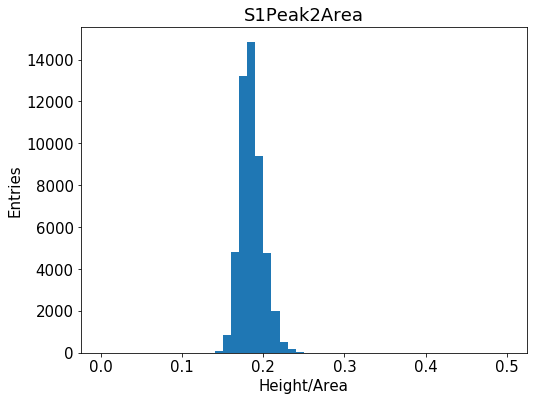

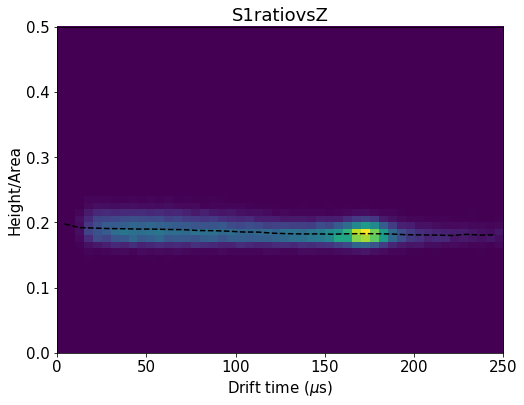

In [46]:
zrange = 0, zcut
rrange = 0, 0.5

S1r = shortZ.S1h/shortZ.S1e
hist(S1r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S1Peak2Area")

hist2d(shortZ.Z, S1r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S1r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S1ratiovsZ")

# S2 energy

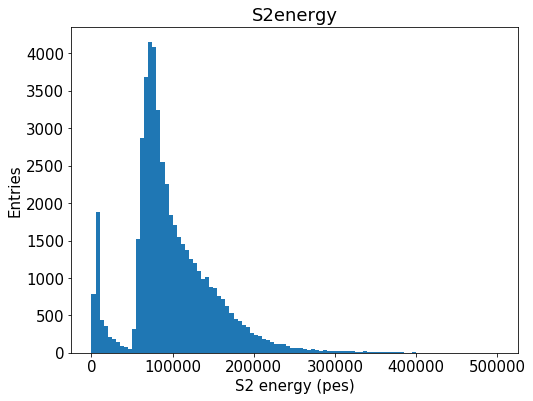

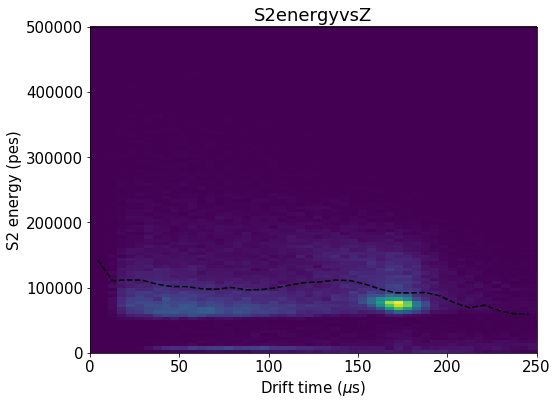

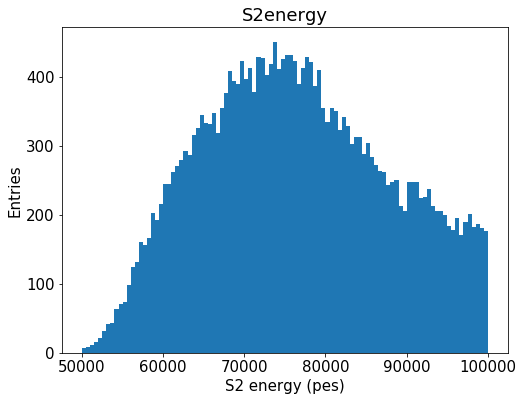

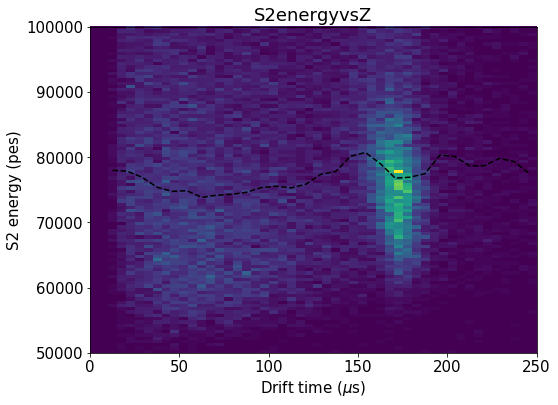

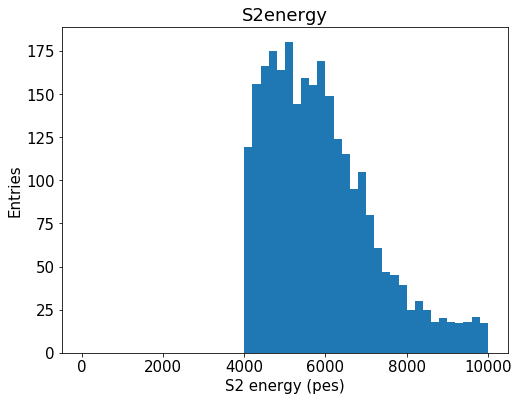

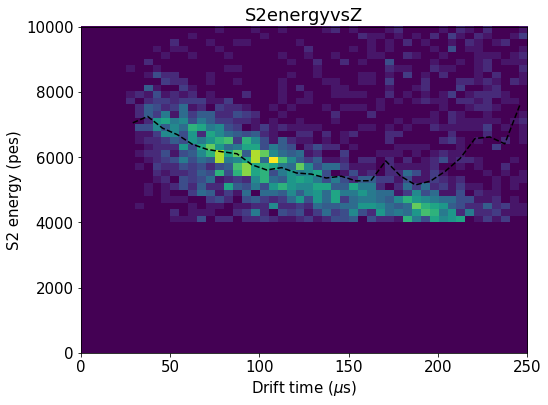

In [47]:
zrange = 0, zcut
Erange = 0, 5e5

hist(shortZ.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z, shortZ.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

Erange = 5e4, 1e5

hist(shortZ.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z, shortZ.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")



Erange = 0, 1e4

hist(shortZ.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z, shortZ.S2e, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

# S2 width

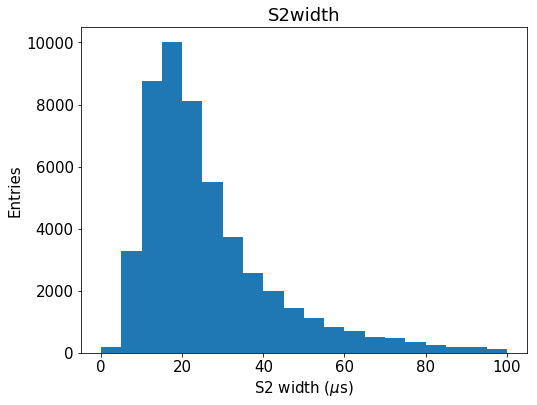

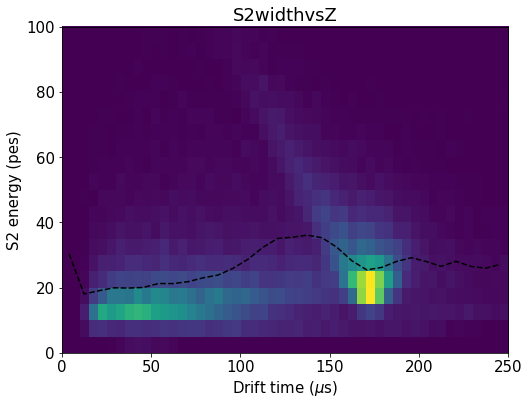

In [48]:
zrange = 0, zcut
wrange = 0, 100

hist(shortZ.S2w, 20, range=wrange)
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

hist2d(shortZ.Z, shortZ.S2w, (50, 20), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2widthvsZ")

# S2 height

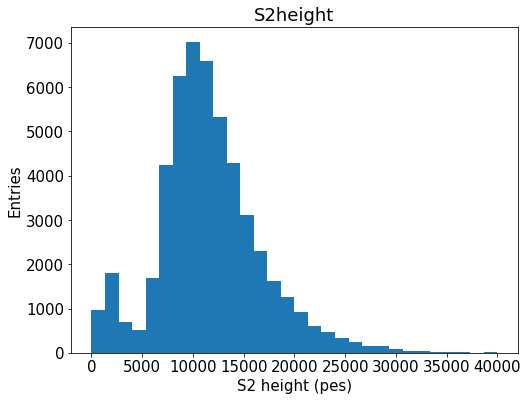

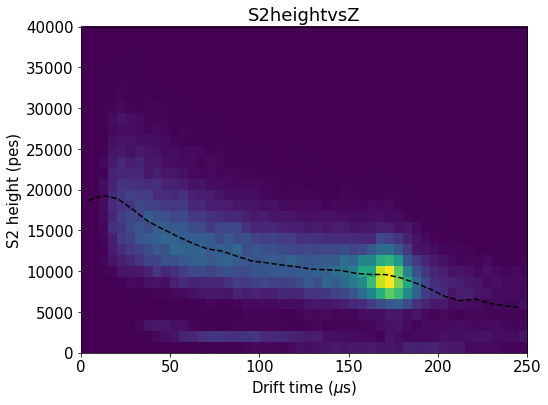

In [49]:
zrange = 0, zcut
hrange = 0, 4e4

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
save("S2height")

hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

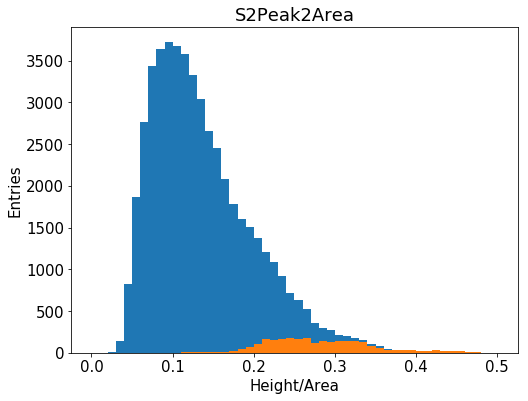

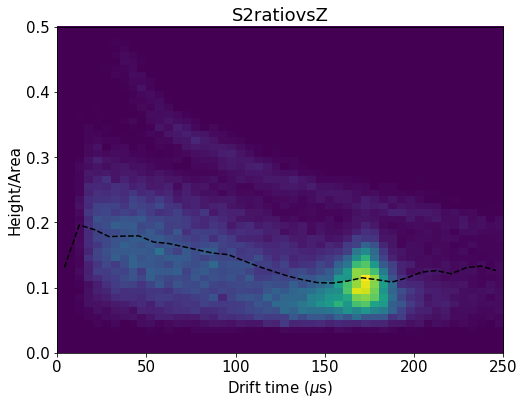

In [50]:
zrange = 0, zcut
rrange = 0, 0.5

S2r   = shortZ.S2h/shortZ.S2e
S2rXR = shortZ.S2h[shortZ.S2e < 1e4]/shortZ.S2e[shortZ.S2e < 1e4]

hist(S2r, 50, range=rrange)
plt.hist(S2rXR, 50, range=rrange)
labels("Height/Area", "Entries")
save("S2Peak2Area")

hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S2ratiovsZ")


# S2 vs S1

[  1.58829554e+03   8.86534170e+08] [[-0.9999994  -0.00109904]
 [ 0.00109904 -0.9999994 ]]


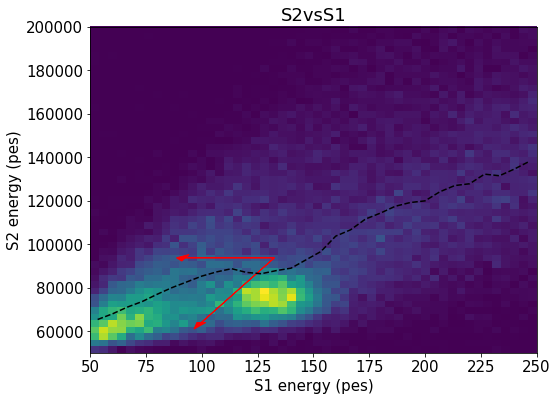

In [51]:
Srange = 50, zcut
Erange = 5e4, 2e5

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

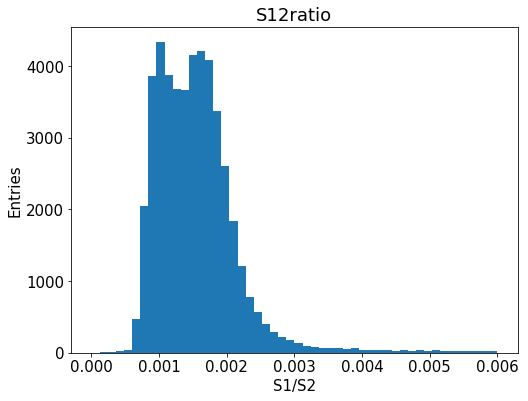

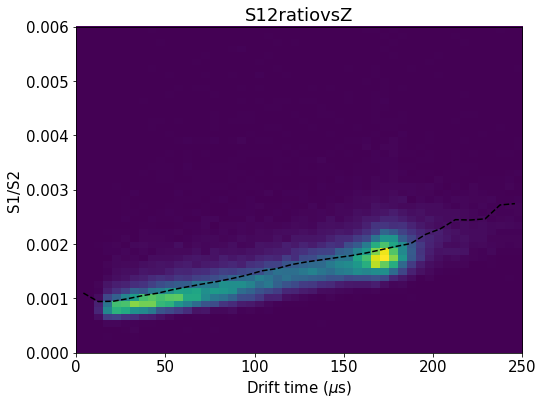

In [52]:
zrange = 0, zcut
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Pick XRays

In [56]:
XR = shortZ[shortZ.S2e < 8e3]

# Temporary fiducialization

In [57]:
rfid = 100
XRfid = XR[XR.R < rfid]
print("Ratio:", len(XRfid)/len(full))
print("Ratio:", len(XRfid)/len(XR))
shortZfid.head()

Ratio: 0.018765795330240278
Ratio: 0.40662035145075603


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
60,22207,1.491517e+09,1,2,225.0,28.579346,161.185127,521875.0,8.339313,1137.746338,...,688637.5,1.0,166.7625,166.7625,55.000000,25.000000,60.415230,0.426627,0.000000,0.000000
85,22238,1.491517e+09,1,2,250.0,21.733898,133.757807,578100.0,9.105875,1368.932739,...,730237.5,3.0,152.1375,152.1375,-52.123646,-27.632376,58.995107,-2.654132,4.544368,4.421186
210,22372,1.491517e+09,1,2,175.0,14.548591,72.390917,599050.0,5.962500,1750.035767,...,696087.5,2.0,97.0375,97.0375,-45.000000,50.592418,67.709621,2.297758,0.000000,5.000243
262,22427,1.491517e+09,1,2,175.0,16.660017,84.891372,593775.0,11.160000,1375.217773,...,840062.5,3.0,246.2875,246.2875,81.885186,-17.311471,83.695105,-0.208344,4.647497,4.230689
334,22502,1.491517e+09,1,2,250.0,52.666561,300.082150,631525.0,9.921250,1999.907471,...,729612.5,4.0,98.0875,98.0875,39.481495,-18.554715,43.624144,-0.439328,4.983377,4.796507


# S2 energy fiducialized

[ 8398.26812397  -307.3055197 ]


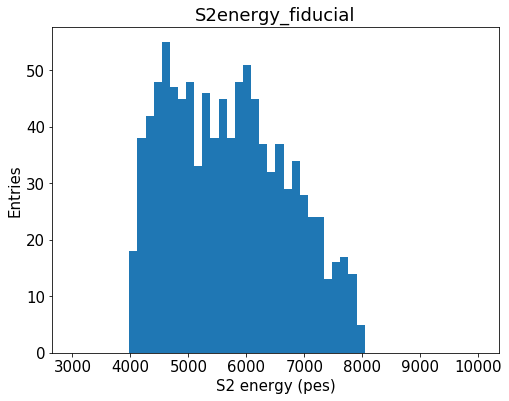

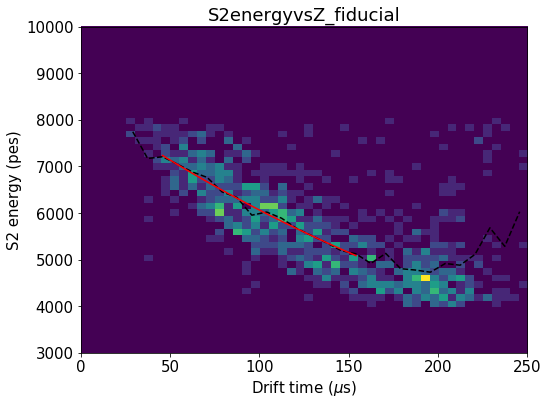

In [58]:
zrange = 0, zcut
Erange = 3e3, 1e4

hist(XRfid.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(XRfid.Z, XRfid.S2e, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(XRfid.Z, XRfid.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 40, 160)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

[ 7317.09864998 -6614.85336649]


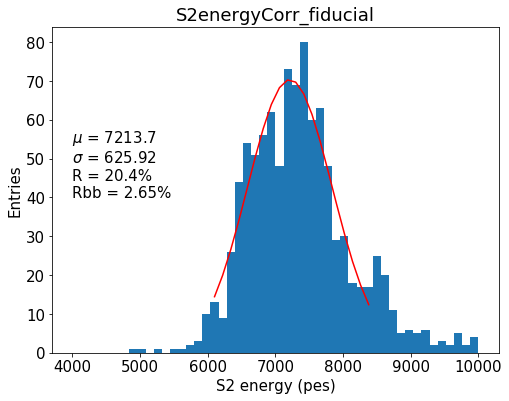

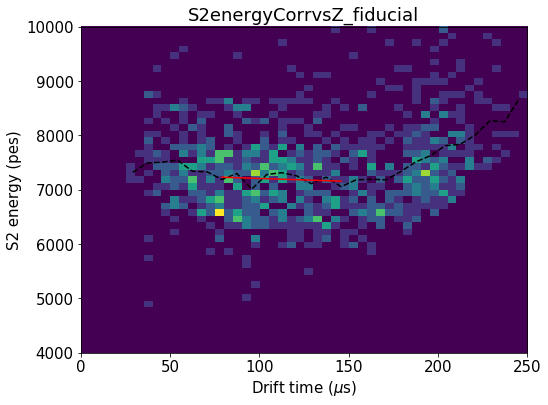

In [61]:
zrange = 0, zcut
Erange = 4e3, 1e4

E = shortZfid.S2e * zcorr(shortZfid.Z)

y, x, _ = hist(E, 50, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")
save("S2energyCorr_fiducial")

hist2d(shortZfid.Z, E, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

# Tracking

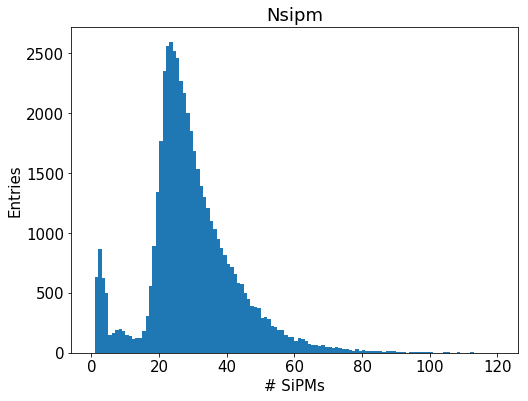

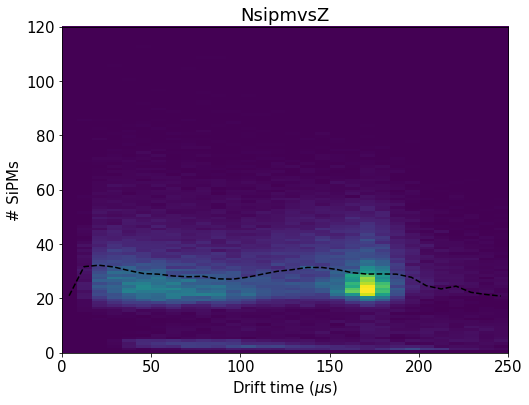

In [62]:
nrange = 0, 120
zrange = 0, zcut

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


# Event distribution

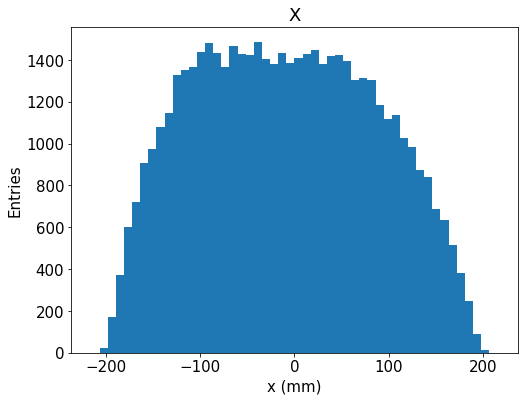

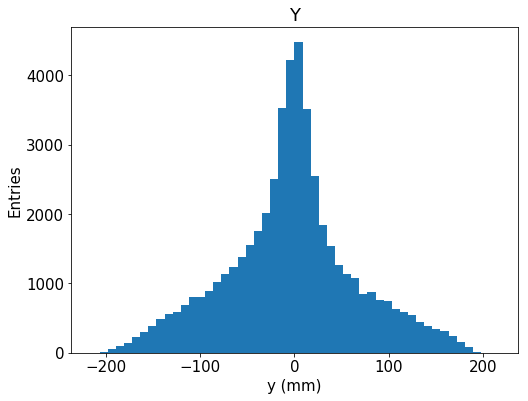

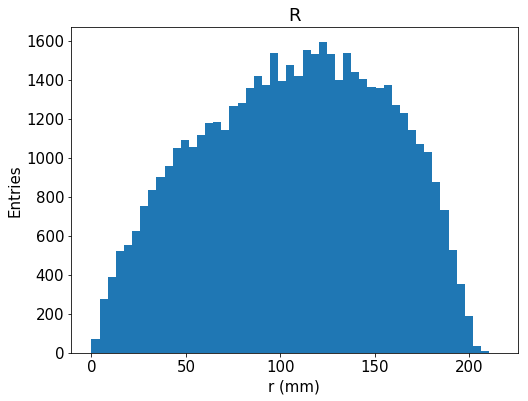

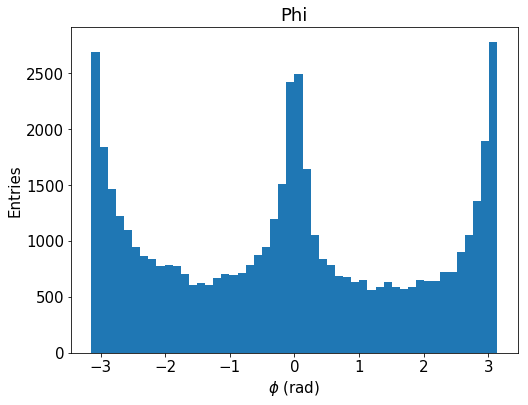

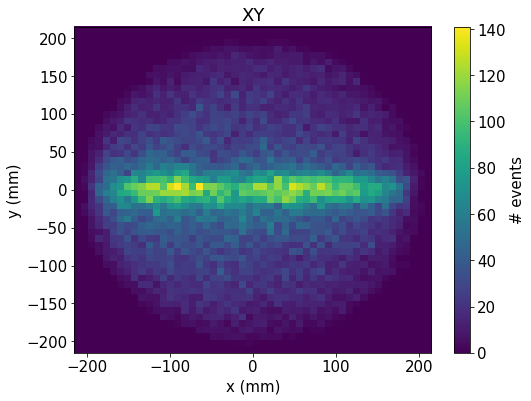

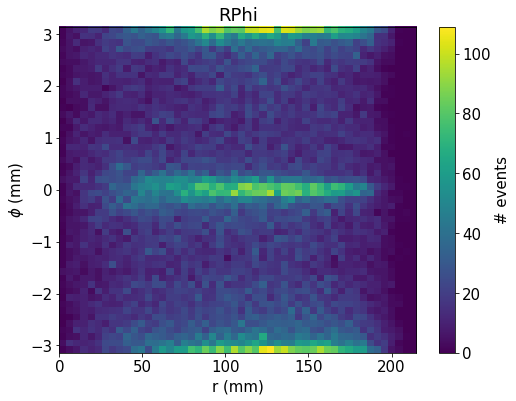

In [63]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(shortZ.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(shortZ.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(shortZ.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(shortZ.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(shortZ.X, shortZ.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(shortZ.R, shortZ.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

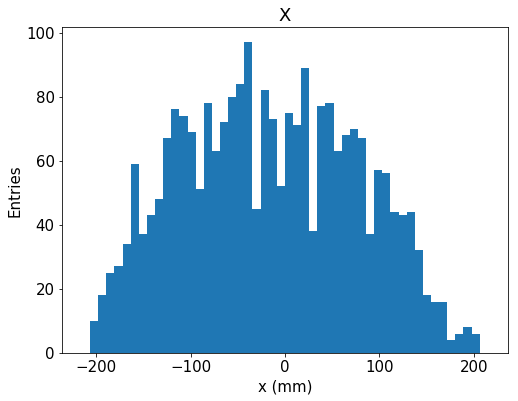

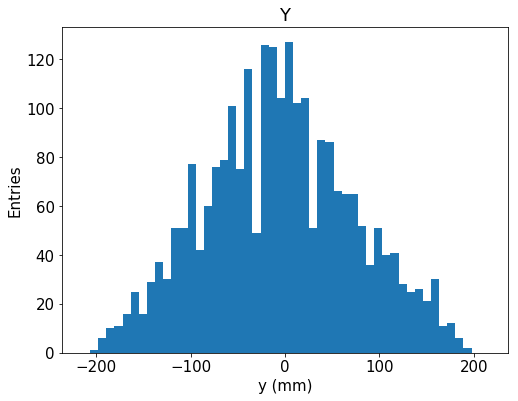

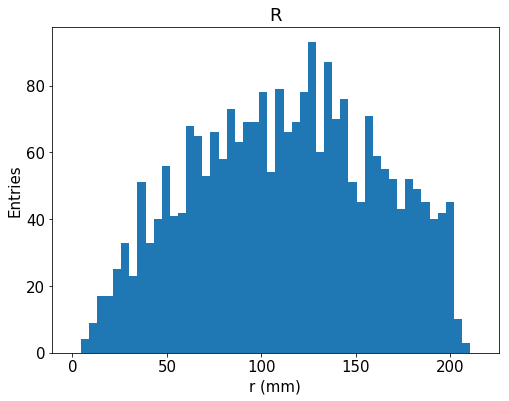

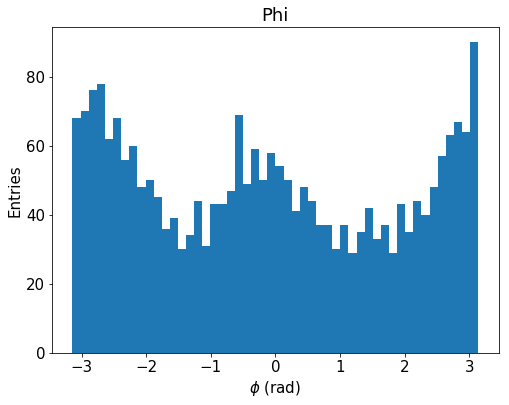

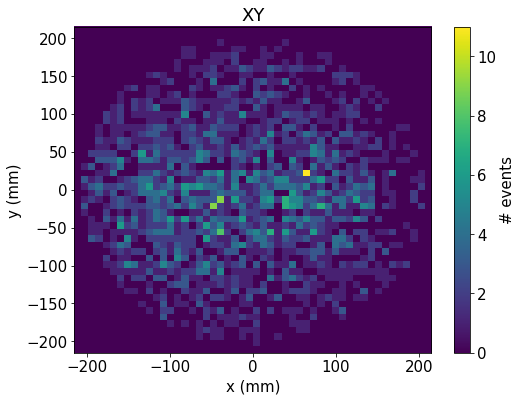

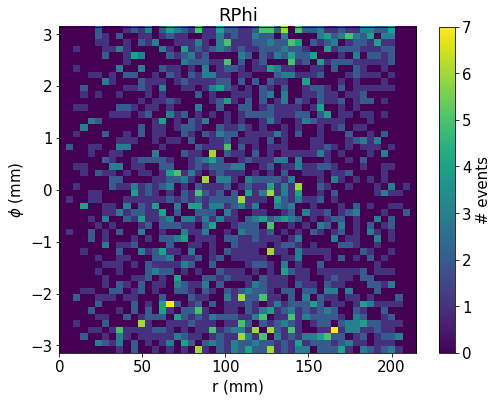

In [64]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(XR.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(XR.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(XR.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(XR.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(XR.X, XR.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

hist2d(XR.R, XR.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

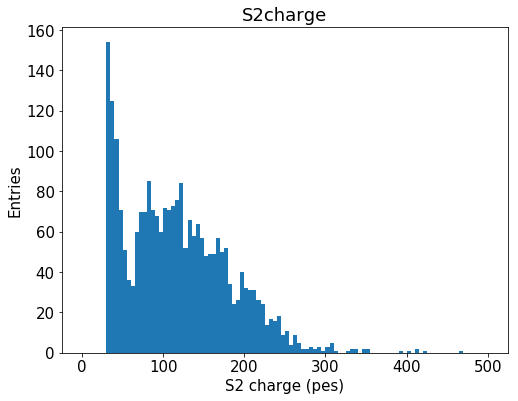

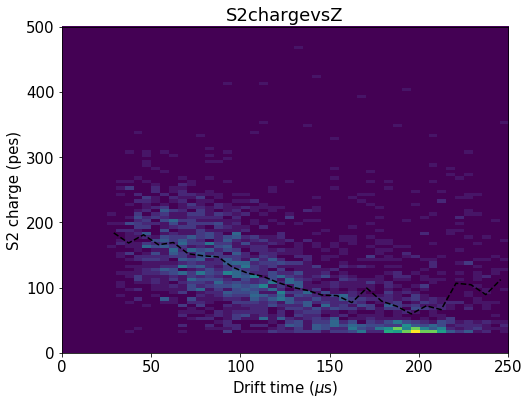

In [65]:
zrange = 0, zcut
Qrange = 0, 500

hist(XR.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(XR.Z, XR.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(XR.Z, XR.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

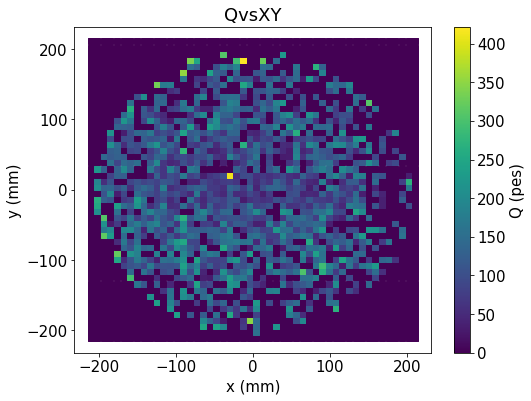

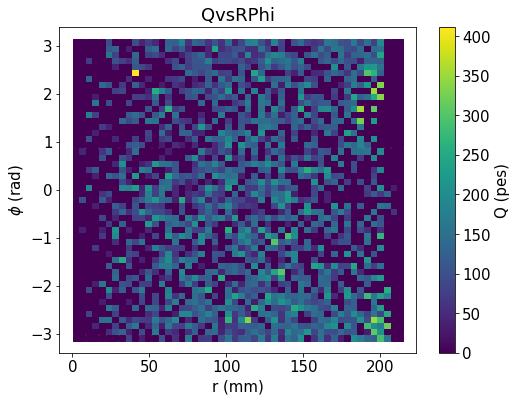

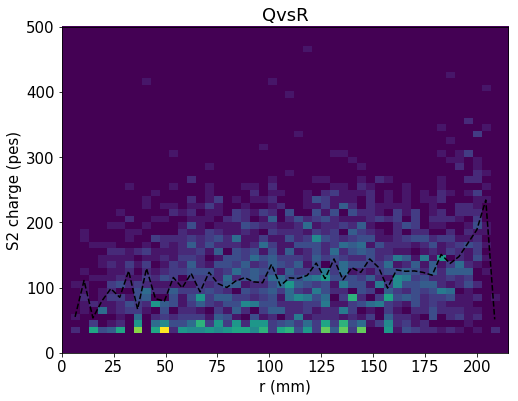

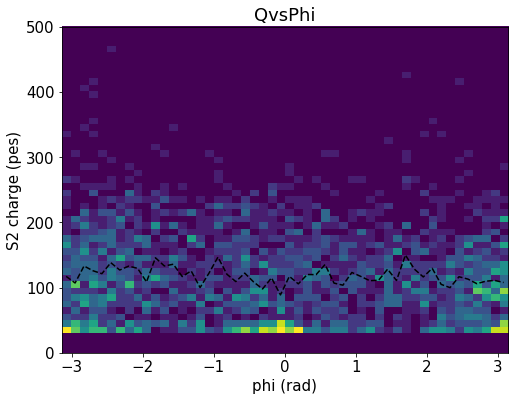

In [66]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

_, _, cb = profile_and_scatter(XR.X, XR.Y, XR.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, XR.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(XR.R, XR.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(XR.R, XR.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(XR.Phi, XR.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(XR.Phi, XR.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

7086.02336485


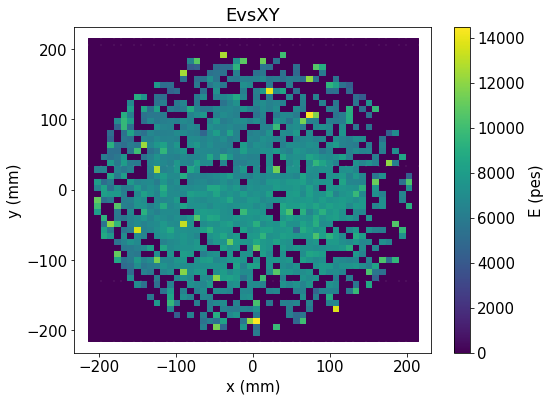

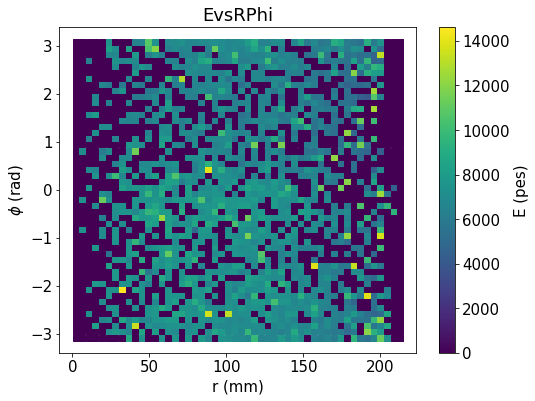

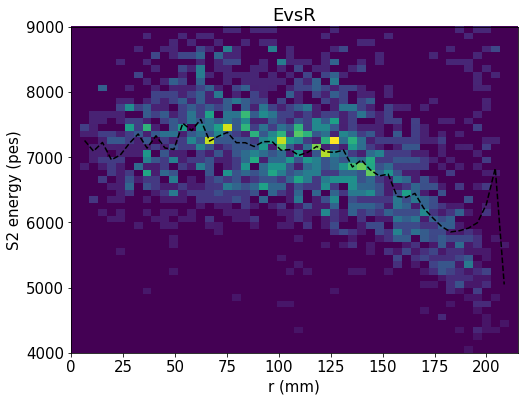

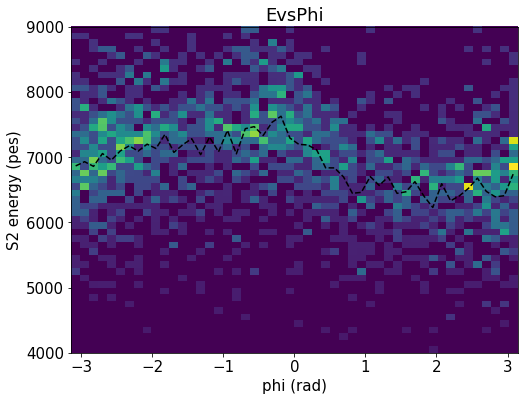

In [67]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = XR.S2e * zcorr(XR.Z)

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

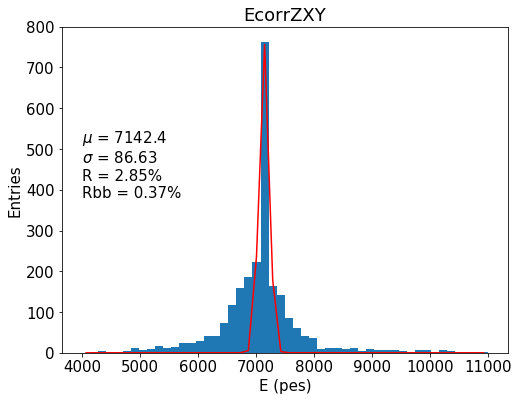

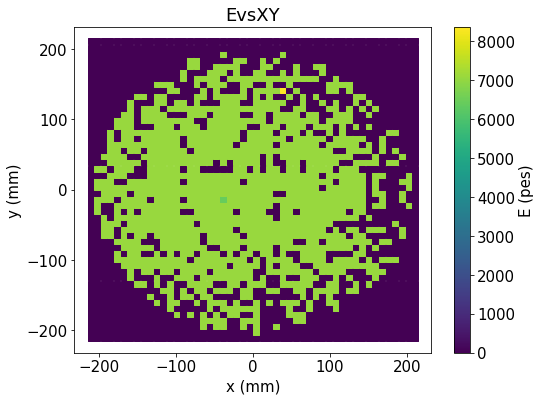

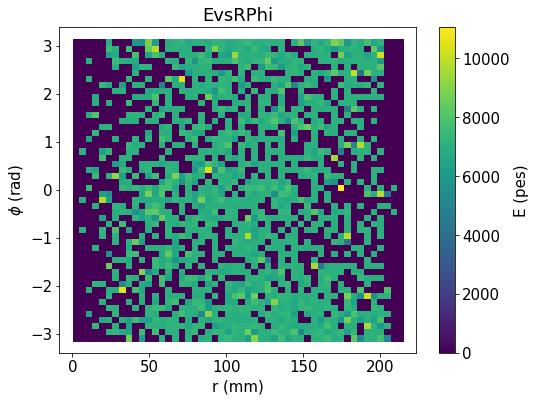

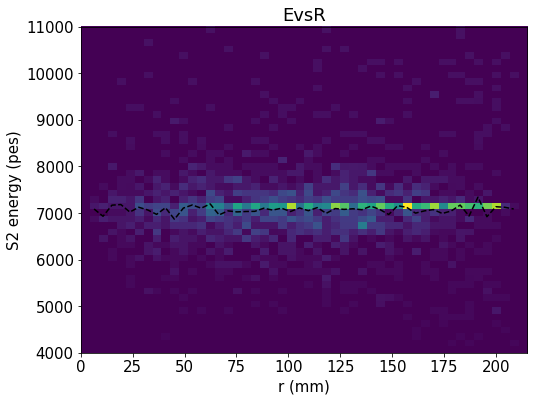

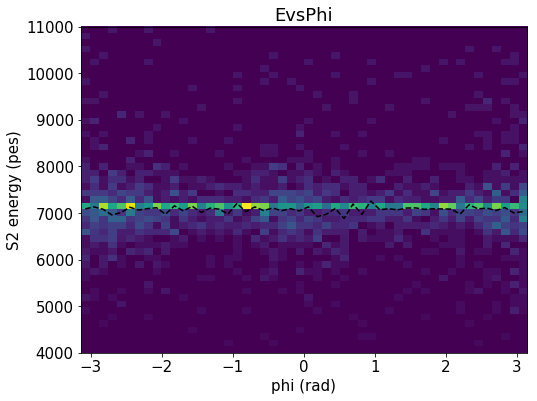

In [73]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3
#Erange = 6500, 7500
E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 7e3, 5e2), fit_range=(6500, 8000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


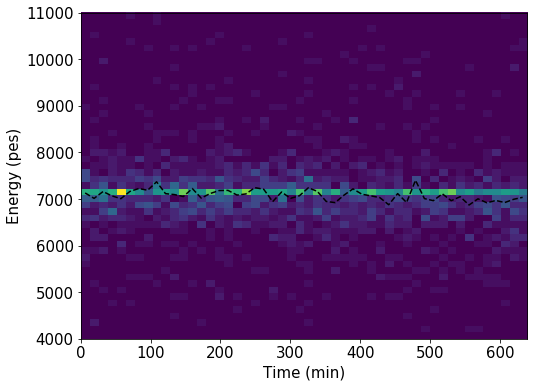

In [74]:
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)
T = (XR.time - np.min(XR.time))/60

Erange = 4e3, 11e3
Trange = np.min(T), np.max(T)

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

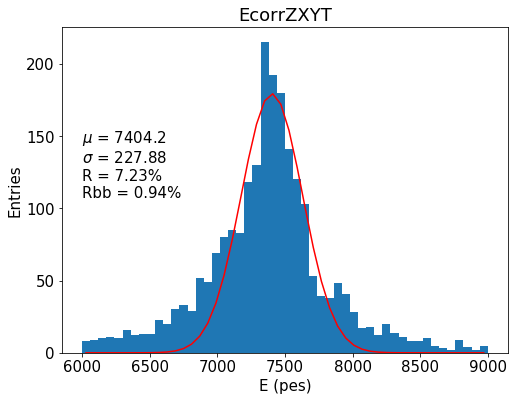

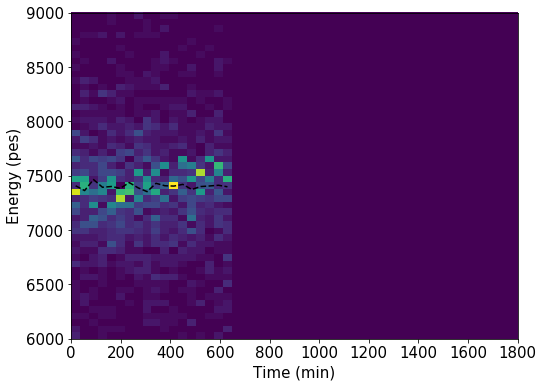

In [86]:
T = (XR.time - np.min(XR.time))/60
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values) * tcorr(T)

Trange =   0, 1800
Erange = 6e3, 9e3

y, x, _ = hist(E, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 7e3, 1e2), fit_range=(7e3,8e3))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")


In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e4, 1e5

E = XR.S2e * zcorr(XR.Z)

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])
